![title](./images/policia.png)

# En este ejercicio, el ordenador va a entender que está leyendo.
<br>

 <div class="alert alert-block alert-info">
El <strong>topic modelling</strong> se usa para categorizar grupos de documentos. <br>
Se usa cuando tienes un "corpus" de muchos documentos -redes sociales, panama papers- y quieres saber como categorizar cada una de los documentos.

</div>

 
<div class="alert alert-block alert-success">
El algoritmo <strong>Latent Dirichlet Allocation (LDA)</strong> genera un grupo de categorías, donde cada categoría es un conjunto de tópicos y las frecuencias con la importancia relativa de cada tópico en esa categoria.

Presupone que cada documento es una mezcla de un pequeño número de categorías (también denominados como tópicos) y la aparición de cada palabra en un documento se debe a una de las categorías a las que el documento pertenece.
<div>

<br>

<img src="./images/trivial.jpg" alt="topic modeling interactive visualization" align="left"></img>


## Contenidos ##
- ### Extracción de tópicos con lda
- ### Generación de topicos
- ### Resultados : Heatmap
- ### Resultados : Interactive topic model visualization

In [4]:
#### Analicemos este hashtag ####
hashtag = "@policia"

Nos conectamos al api de tweeter para extraer los tópicos.

In [ ]:
###### Nos conectamos a tweeter 
(para usar esto hay que arreglar las variables con los token de conexion), y descomentar el guardado a disco.

import tweepy
import csv
import pandas as pd
from datetime import date, timedelta

####
# Quitamos la primera letra de las variables, y ponemos un guión para despistar a los parser
onsumer_key    = 'h_mFJIxaV0HqCuKVZc8iZL65sJ'
onsumer_secret = 'l_eDBguzuUDqd4v2YwKf9cYywWBWEDX4XV341HVdLHC18n1C7kP'
ccess_token    = '7_92058678581026816-ZZk5lNrzMcLJdHRrRLMn6LIksQLDZTi'
ccess_token_secret   = 'z_skKIFghdWezAgpChHLGrVX6OtZPBOmSOvG1tPMtWlK6b'

print(" Nos conectamos a twitter" )


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

options = " -filter:retweets"
array = []

# Pedimos datos al api
for tweet in tweepy.Cursor(api.search , count=100,q=hashtag + options, lang="es", tweet_mode="extended").items(5000) :
    array.append({"hashtag" : hashtag  , 
                  "tweet" : tweet.full_text,
                  "link" : "https://twitter.com/"+ tweet._json["user"]["screen_name"] + "/status/" + tweet.id_str ,
                 })

# Guardar a disco    
df = pd.DataFrame(array)

### Descomentar para guardar a disco
### df.to_csv('datasets/lda.csv',index=False)
tweets = df 

print(" Acabamos de descargarnos",df.size,"tweets de " , hashtag )
df.head(5)


In [5]:
#########################################
### Cargamos el DataFrame, desde un csv.
### Por si no los hemos descargado
#########################################
import pandas as pd
tweets = pd.read_csv('datasets/lda.csv',encoding = 'utf8')
tweets["tweet"] = tweets["tweet"].replace("telefónica","telefonica").replace("?"," ").replace(","," ").replace("."," ").replace(hashtag,"").replace(tweets.head(1).hashtag.values[0].lower(),"")
corpus = tweets.tweet 

hashtag = [tweets.head(1).hashtag.values[0].lower()]

print(corpus.values)


['@wallapop hola, he comprado unos articulos a un usuario y le hice la transferencia el sabado 8 de septiembre y todavia no ha enviado nada, le pregunte ayer y no ha contestado.Hay alguna forma de reclamar son denunciarlo a la @policia?Tengo numero de cuenta y nombre y conversación'
 '@policia una consulta sobre el DNI. Si está deteriorado y lo llevo a hacer nuevo, los 10 años de validez son desde la fecha de renovación nueva o la que pone en el DNI. Lo mismo para pasaporte.'
 '@beticoteletexto @EmergenciasSev @policia @Ayto_Sevilla @SubdeGobSevilla Un par de días no será hasta que otro barrio tenga problemas y los denuncie en prensa. Los políticos han dejado morir a la policía local y no hay para todos los barrios y para tantas procesiones'
 ...
 '@Alfonso_Egea\n@policia el seor @willynotas23 les acusa de torturas observadas por el susodicho cuando estuvo detenido con anterioridad por motivo de una HUELGA. Como español me gustaría que LO DESMINTIERAN/DENUNCIARAN sino nadie LES RESPETA

In [6]:
from string import punctuation

# remove common words and tokenize
list1 = ['RT','rt', '&gt;&gt;' "&amp;" ,"?" , "," ]
from stop_words import get_stop_words
##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
stoplist  = get_stop_words('spanish') + list1 + hashtag
## Añdimos nuestras propias palabras


texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
print(texts[:5])

[['@wallapop', 'hola,', 'comprado', 'articulos', 'usuario', 'hice', 'transferencia', 'sabado', '8', 'septiembre', 'todavia', 'enviado', 'nada,', 'pregunte', 'ayer', 'contestado.hay', 'alguna', 'forma', 'reclamar', 'denunciarlo', '@policia?tengo', 'numero', 'cuenta', 'nombre', 'conversación'], ['consulta', 'dni.', 'si', 'deteriorado', 'llevo', 'hacer', 'nuevo,', '10', 'años', 'validez', 'fecha', 'renovación', 'nueva', 'pone', 'dni.', 'mismo', 'pasaporte.'], ['@beticoteletexto', '@emergenciassev', '@ayto_sevilla', '@subdegobsevilla', 'par', 'días', 'barrio', 'problemas', 'denuncie', 'prensa.', 'políticos', 'dejado', 'morir', 'policía', 'local', 'barrios', 'tantas', 'procesiones'], ['@mariaquilezv', 'apoyo,', 'gran', 'persona.', 'sigue', 'asi', 'cambies', 'nunca!!!!', 'mejor'], ['@socenm', '@angelsanandreu', '@angeljrep', '@guardiacivil', 've', 'pie', 'polla,', 'pequeña', 'https://t.co/ow1roxxlcz']]


In [8]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(texts)

dictionary

In [9]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1)],
 [(59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1)],
 [(68, 1), (70, 1), (71, 1), (77, 1), (78, 1), (79, 1)],
 [(78, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  

In [13]:
from gensim import corpora, models, similarities
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors


In [14]:
total_topics = 15
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


In [15]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)


[(0,
  '0.070*"@jusapol" + 0.041*"@guardiacivil" + 0.038*"#equiparacionya" + 0.026*"@ppopular" + 0.025*"#grupob_reclasificacionya"'),
 (1,
  '0.021*"@guardiacivil" + 0.008*"mismo" + 0.008*"@jusapol" + 0.005*"seguridad" + 0.004*"si"'),
 (2,
  '0.016*"@guardiacivil" + 0.008*"@arran_jovent" + 0.008*"@cupnacional" + 0.008*"@sepc_nacional" + 0.008*"@endavant_osan"'),
 (3,
  '0.031*"@jusapol" + 0.030*"@guardiacivil" + 0.018*"@sanchezcastejon" + 0.018*"@erikeo5555" + 0.017*"#equiparacionya"'),
 (4,
  '0.008*"@consumidores" + 0.006*"@guardiacivil" + 0.005*"@ayto_sevilla" + 0.005*"tener" + 0.005*"@diariosevilla"'),
 (5,
  '0.009*"@guardiacivil" + 0.009*"@perdiguerosipep" + 0.006*"jajajaja" + 0.004*"@europarl_es" + 0.004*"hola"'),
 (6,
  '0.013*"@guardiacivil" + 0.012*"@elprogramadear" + 0.008*"@jusapol" + 0.006*"si" + 0.005*"q"'),
 (7,
  '0.016*"d" + 0.015*"q" + 0.012*"@guardiacivil" + 0.008*"@facua" + 0.007*"@ppsenado"'),
 (8,
  '0.014*"@guardiacivil" + 0.008*"si" + 0.007*"@jusapol" + 0.005*"v

In [16]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(283, 15)
(15, 283)


In [45]:
df_lda


,!!,#29sbarcelona,#equiparacionya,#grupob_reclasificacionya,#pnygcnoserinden,&amp;,.,1,2019,23,...,tweet,twitter,usan,usted,ver,vida.,x,|,¿es,único
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.002897,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.002735,0.000000,0.000000,0.000000,0.000000,0.000000,0.00337,0.000000,0.002372,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.003104,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.003471,...,0.000000,0.00000,0.000000,0.002306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.012273,0.005550,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.003137,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.006175,0.000000,0.000000,0.002474,0.000000,0.000000,0.000000,0.003576
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.003656,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.007448,0.000000,0.002816,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


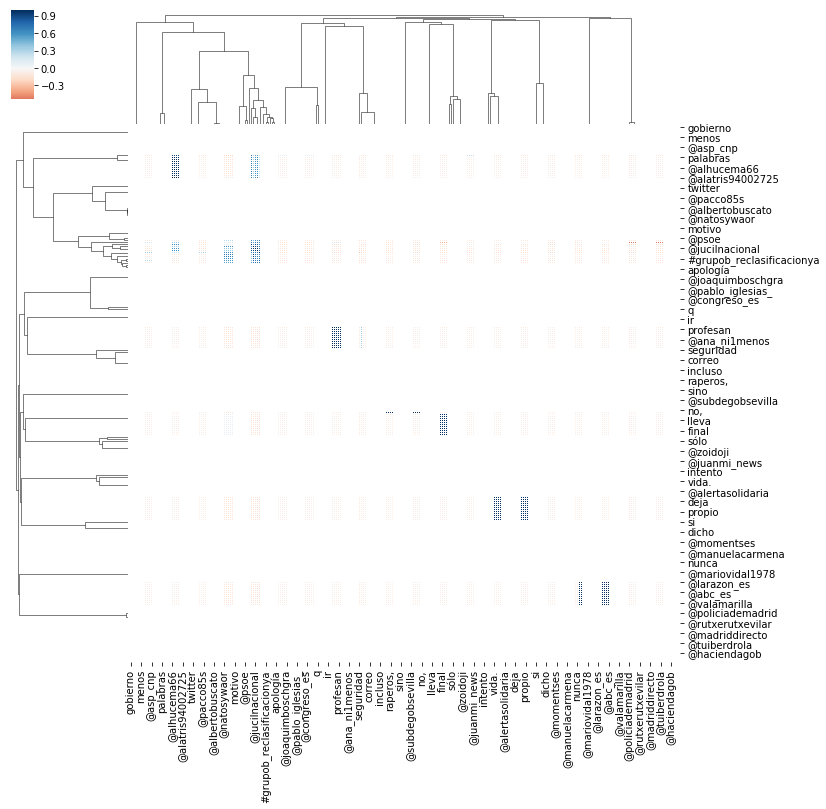

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [47]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
4      45.464211        1       1  306.435181   33.388271
3       9.837436        1       2   44.648014 -213.027405
5       4.201130        1       3  -95.619431 -178.592072
14      3.749589        1       4  -13.771033  168.626434
12      3.361722        1       5  219.349640  139.969421
11      3.338593        1       6 -117.267395   92.746826
10      3.338593        1       7  259.178497  -96.381157
8       3.338593        1       8   92.347923   83.799202
6       3.338593        1       9  105.490837  -74.445160
2       3.338593        1      10  109.384575  216.769791
1       3.338593        1      11   -2.841284   25.060608
0       3.338593        1      12  172.276489 -188.611176
13      3.338592        1      13 -131.617172  -39.265358
9       3.338592        1      14  179.027618    9.181633
7       3.338592        1      15   -6.043310  -89.263916, topic_info=      Category       Freq                       Term      Total  loglift  \
term                                                                       
141    Default  29.000000                   @jusapol  29.000000  30.0000   
70     Default  59.000000              @guardiacivil  59.000000  29.0000   
4878   Default  11.000000                    @yozatu  11.000000  28.0000   
4873   Default  11.000000           @franklintshimin  11.000000  27.0000   
4876   Default  11.000000                @natosywaor  11.000000  26.0000   
4872   Default  11.000000            @factoria_ritmo  11.000000  25.0000   
4874   Default  11.000000             @hiphoplifemag  11.000000  24.0000   
4870   Default  11.000000                 @ayaxyprok  11.000000  23.0000   
4871   Default  11.000000              @elchojin_net  11.000000  22.0000   
4875   Default  11.000000                 @nachsoyyo  11.000000  21.0000   
4877   Default  11.000000                 @piezas750  11.000000  20.0000   
702    Default  14.000000            #equiparacionya  14.000000  19.0000   
4869   Default  11.000000            @albertobuscato  11.000000  18.0000   
11959  Default  27.000000            @manuelacarmena  27.000000  17.0000   
543    Default  11.000000                  @ppopular  11.000000  16.0000   
39     Default  38.000000                         si  38.000000  15.0000   
4294   Default   8.000000           @policiademadrid   8.000000  14.0000   
203    Default   8.000000                          d   8.000000  13.0000   
703    Default   6.000000  #grupob_reclasificacionya   6.000000  12.0000   
4982   Default   5.000000                 @senadoesp   5.000000  11.0000   
3487   Default   7.000000                      @psoe   7.000000  10.0000   
708    Default   8.000000                    gracias   8.000000   9.0000   
218    Default  12.000000                          q  12.000000   8.0000   
541    Default   6.000000              @pablocasado_   6.000000   7.0000   
8165   Default  15.000000                 @momentses  15.000000   6.0000   
14409  Default   5.000000              @consumidores   5.000000   5.0000   
130    Default   8.000000           @sanchezcastejon   8.000000   4.0000   
4824   Default   3.000000                @jandrolion   3.000000   3.0000   
3652   Default  10.000000                    escrito  10.000000   2.0000   
14970  Default   2.000000                    @madrid   2.000000   1.0000   
...        ...        ...                        ...        ...      ...   
3161   Topic15   0.790325                    @iunida   1.497036   2.7608   
8730   Topic15   0.314265                      caso,   0.488222   2.9591   
2224   Topic15   0.419274                      final   0.731608   2.8429   
2385   Topic15   0.261692                      malos   0.410415   2.9496   
1724   Topic15   0.389233                      lleva   0.749933   2.7438   
4814   Topic15   0.351029                      nivel   0.849642   2.5157   
4869   

<img src="./images/topic-modeling.png" alt="topic modeling interactive visualization" align="left"></img>


La extracción de tópicos puede responder a preguntas tales como : ¿ De qué están hablando nuestros clientes ?
